# Topicanalyse

<h3>Packages und Funktionen</h3>

In [1]:
import json, gensim
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
%%html
<style>
table {float:left}
</style>

In [3]:
def loadjson(filename):
    import json
    with open((filename+'.json'), 'r') as f:
        file = json.loads(f.read())
    print(len(file))
    return file

def savejson(file, filename):
    with open((filename+'.json'), 'w') as f:
        json.dump(file, f)
    print(True)

In [4]:
def print_topics(model, dictionary, num_topics, num_terms):
    for i in list(range(num_topics)):
        print('Topic ' + str(i+1) + ':')
        for wordid, prob in model.get_topic_terms(i, num_terms):
            print(dictionary[wordid], prob)
        print(' ')

def get_topicprob_per_topic(topic, corpus, ldamodel):
    topicprobs = []
    for i in range(len(corpus)):
        topicprob = 0.0
        topics = ldamodel.get_document_topics(corpus[i])
        for topicid, prob in topics:
            if topicid == topic:
                topicprob = prob
        topicprobs.append(topicprob) 
    return topicprobs

def getyearprobs(problist, yearlist):
    yearprobs = []
    avg_score=sum(problist)/len(problist)
    for year,count in list(Counter(yearlist).items()):
        avg=sum(problist[:count])/count
        yearprobs.append((year,avg))
        problist=problist[count:]    
    return yearprobs

def doit(topicid, corpus, model):
    problist = get_topicprob_per_topic(topicid, corpus, model)
    #print(len(problist))
    avglist = getyearprobs(problist, yearlist)
    #print(len(avglist))
    return (avglist)

def score_norm(scorelist, omit_n):
    avg = sum([x[1] for x in scorelist][omit_n:])/len(scorelist[omit_n:])
    score_final=[(k, v/avg) for k,v in scorelist]
    #print(len(score_final))
    return score_final

<h3>Metadaten</h3>

Zur temporalen Topicanalyse wird ein Korpus aus 7059 Untertiteln verwendet. Während das Trainingskorpus aus 33___ Dokumenten bestand und damit pro Film mehrere Untertitelversionen umfasste, ist im Anwendungskorpus jeder Film genau einmal enthalten. Die Metadaten ordnen jeder Film-ID die Daten Entstehungsjahr, Genre, Entstehungsort und Dateiname zu.

In [5]:
metadata = loadjson('final/metadata')

7059


In [6]:
list(metadata.items())[:20]

[('417', ['1902', 'Adventure,Fantasy,Sci-Fi', 'France', '3618644.xml']),
 ('2113', ['1912', 'Adventure,Sci-Fi,Short', 'France', '3331483.xml']),
 ('6820', ['1916', 'Horror,Sci-Fi', 'Germany', '4445651.xml']),
 ('337377', ['1921', 'Comedy,Horror,Sci-Fi', 'Italy', '3663567.xml']),
 ('15214', ['1924', 'Sci-Fi,Short', 'France', '147727.xml']),
 ('228425', ['1925', 'Sci-Fi', 'Germany', '4194519.xml']),
 ('17744', ['1927', 'Sci-Fi,Short', 'France', '4735110.xml']),
 ('17136', ['1927', 'Drama,Sci-Fi', 'Germany', '4229551.xml']),
 ('21884', ['1931', 'Drama,Horror,Sci-Fi', 'USA', '3178482.xml']),
 ('21864', ['1931', 'Sci-Fi', 'France', '4443400.xml']),
 ('22835', ['1931', 'Horror,Sci-Fi', 'USA', '100628.xml']),
 ('23194', ['1932', 'Adventure,Horror,Sci-Fi', 'USA', '3358518.xml']),
 ('24188', ['1932', 'Horror,Sci-Fi', 'USA', '4398569.xml']),
 ('159057', ['1933', 'Drama,Sci-Fi', 'Germany', '6294712.xml']),
 ('23938', ['1933', 'Drama,Sci-Fi', 'USA', '6945584.xml']),
 ('24216', ['1933', 'Adventure,

Die Entstehungsjahre werden in ihrer Zuordnung zur entsprechenden Halbdekade in einer Liste gespeichert und gezählt, um später die Durchschnitte der Topicwahrscheinlichkeiten über die jeweiligen Zeiträume bilden zu können.

In [7]:
yearlist=[]
for item in metadata.items():
    year = int(item[1][0])
    yearlist.append(year-(year%5))
len(yearlist)

7059

In [8]:
Counter(yearlist)

Counter({1900: 1,
         1910: 1,
         1915: 1,
         1920: 2,
         1925: 3,
         1930: 9,
         1935: 14,
         1940: 10,
         1945: 5,
         1950: 26,
         1955: 78,
         1960: 112,
         1965: 227,
         1970: 108,
         1975: 247,
         1980: 231,
         1985: 279,
         1990: 324,
         1995: 887,
         2000: 800,
         2005: 989,
         2010: 1579,
         2015: 1126})

<h3>Korpus</h3>

Das Analysekorpus setzt sich aus jenen Untertiteldateien zusammen, die in den Metadaten aufgeführt sind. Der folgende Code dient dazu, die Dateipfade zu rekonstruieren, die Dateien einzulesen und in einer String-Liste zu speichern.

In [ ]:
films = []
for film in list(metadata.items()):
    year = int(film[1][0])
    year -= year%5
    filepath = 'final/subtitleData/{}_{}/{}.txt'.format(year,year+5,film[1][3])
    #print(filepath)
    with open(filepath, 'r') as f:
        films.append(f.read())
len(films)

Wie bei der Erstellung des Trainingskorpus werden die Texte zunächste mithilfe von NLTK tokenisiert und von Stoppwörtern und sehr kurzen Wörtern befreit sowie in lowercase umgewandelt.

In [10]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words=stopwords.words('english')
len(stop_words)

179

In [ ]:
films_tokenized = [word_tokenize(film) for film in films]

In [28]:
films_clean = [[w.lower() for w in film if w.isalpha() and len(w)>2 and w.lower() not in stop_words] for film in films_tokenized]
len(films_clean)

7059

In [90]:
films_clean[0][:20]

['trip',
 'moon',
 'george',
 'melies',
 'astronomers',
 'assembled',
 'large',
 'hall',
 'embellished',
 'instruments',
 'president',
 'members',
 'committee',
 'enter',
 'everybody',
 'takes',
 'seat',
 'entrance',
 'six',
 'carrying']

In [30]:
savejson(films_clean, 'final/films_clean')

True


In [10]:
films_clean = loadjson('final/films_clean')

7059


<h3>Loading data</h3>

Im nächsten Schritt werden die beiden Topic Models mit den zugehörigen Wörterbüchern geladen und erneut visualisiert. <code>model1</code> bezeichnet dabei das Modell mit 23 Topics, <code>model2</code> das mit 30 Topics. In der folgenden Tabelle können die Daten eingesehen werden.

| Model  | <code>no_below</code> | <code>no_above</code> | <code>len(dictionary)</code> | <code>num_topics</code> | <code>passes</code> | <code>alpha</code> | <code>eta</code> |
| :- | -: | -: | -: | -: | -: |:- | :- |
| <code>model1</code> | 100 | .35 | 19761 | 23 | 10 | auto | auto |
| <code>model2</code> | 500 | .35 | 7261 | 30 | 10 | auto | auto |

<b>Model 1</b>

In [11]:
dictionary1 = gensim.corpora.Dictionary.load('final/dictionary1')
len(dictionary1)

19761

In [12]:
model1 = gensim.models.LdaModel.load('final/model1_23topics')

In [13]:
corpus1 = [dictionary1.doc2bow(film) for film in films_clean]
len(corpus1)

7059

In [ ]:
print_topics(model=model1, dictionary=dictionary1, num_topics=23, num_terms=50)

In [12]:
import pyLDAvis, pyLDAvis.gensim as ldavis
pyLDAvis.enable_notebook()
import warnings
warnings.filterwarnings('ignore')

In [13]:
vis1 = ldavis.prepare(model1,corpus1,dictionary1,sort_topics=False)
vis1

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.024710 -0.029591       1        1  2.667579
1     -0.176714  0.006331       2        1  9.454272
2     -0.077924  0.094472       3        1  6.970787
3     -0.074949  0.008784       4        1  1.001167
4     -0.160964 -0.106145       5        1  0.745273
5      0.109180 -0.125987       6        1  2.376822
6     -0.121567 -0.077132       7        1  2.415996
7     -0.037572 -0.061425       8        1  6.173282
8     -0.099543  0.107421       9        1  3.425838
9     -0.132619 -0.025711      10        1  3.030513
10     0.062790  0.097053      11        1  4.457325
11     0.064807  0.144506      12        1  6.409457
12     0.244659 -0.094301      13        1  0.704292
13    -0.057145  0.121687      14        1  8.704855
14     0.097218 -0.087952      15        1  1.759404
15    -0.013915  0.041342      16        1  1.355057
16     0.235504  0.001578      17        1  5.103172
17     0.172783 -0.095452      18        1  3.409310
18    -0.104534  0.103791      19        1  6.456590
19     0.030646  0.061589      20        1  6.096655
20    -0.137593 -0.267907      21        1  4.246536
21     0.095148  0.093432      22        1  7.364975
22     0.057594  0.089619      23        1  5.670844, topic_info=         Term          Freq         Total Category  logprob  loglift
3013  captain  14834.000000  14834.000000  Default  30.0000  30.0000
3191     ship  19673.000000  19673.000000  Default  29.0000  29.0000
1309    music   9315.000000   9315.000000  Default  28.0000  28.0000
3439    sighs   6767.000000   6767.000000  Default  27.0000  27.0000
1151    agent   8331.000000   8331.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
587     chief    773.836971   3060.133499  Topic23  -5.9604   1.4950
899     group    744.151415   3207.474243  Topic23  -5.9995   1.4088
5985   threat    680.708713   2122.568769  Topic23  -6.0886   1.7326
242      join    721.015318   3082.369786  Topic23  -6.0311   1.4170
549      pain    724.570316   4549.036573  Topic23  -6.0262   1.0327

[1716 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
14749      7  0.983592      abdul
1144      11  0.034258  abilities
1144      12  0.053044  abilities
1144      13  0.012156  abilities
1144      14  0.014366  abilities
...      ...       ...        ...
9218      19  0.055862     zombie
9219      10  0.823412    zombies
9219      11  0.080426    zombies
9219      19  0.038298    zombies
9219      22  0.053618    zombies

[10247 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])

<b>Model 2</b>

In [14]:
dictionary2 = gensim.corpora.Dictionary.load('final/dictionary2')
len(dictionary2)

7261

In [15]:
model2 = gensim.models.LdaModel.load('final/model2_30topics')

In [16]:
corpus2 = [dictionary2.doc2bow(film) for film in films_clean]
len(corpus2)

7059

In [ ]:
print_topics(model=model2, dictionary=dictionary2, num_topics=30, num_terms=50)

In [17]:
vis2 = ldavis.prepare(model2,corpus2,dictionary2,sort_topics=False)
vis2

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.080510 -0.079452       1        1  2.806578
1      0.196243  0.058638       2        1  7.454236
2      0.005748 -0.040446       3        1  1.271935
3     -0.086681  0.146730       4        1  1.695063
4      0.030848 -0.080322       5        1  5.336591
5     -0.001888  0.055357       6        1  2.414341
6      0.142739  0.094453       7        1  1.503580
7     -0.243947  0.009186       8        1  2.279449
8     -0.108872  0.095003       9        1  2.348056
9      0.063721 -0.127191      10        1  4.746724
10     0.001023  0.090542      11        1  0.884998
11     0.130903 -0.113698      12        1  6.513180
12     0.084255 -0.085978      13        1  1.284583
13    -0.092429 -0.089259      14        1  3.726797
14    -0.090383  0.002354      15        1  4.465408
15     0.112118  0.190540      16        1  4.422272
16     0.103969  0.092668      17        1  3.966484
17    -0.067685 -0.028477      18        1  4.708485
18    -0.066909 -0.168565      19        1  5.155217
19    -0.153051  0.144099      20        1  1.814036
20    -0.139552 -0.075812      21        1  1.894977
21     0.038762 -0.175225      22        1  6.056958
22     0.118868 -0.078874      23        1  3.764752
23     0.007397  0.007497      24        1  0.833307
24     0.042754  0.052774      25        1  2.195507
25     0.055529  0.096870      26        1  1.295058
26    -0.063591  0.112889      27        1  1.047630
27     0.126588  0.003429      28        1  2.382585
28     0.109798 -0.062893      29        1  7.153027
29    -0.175762 -0.046836      30        1  4.578182, topic_info=           Term          Freq         Total Category  logprob  loglift
2302    captain  14682.000000  14682.000000  Default  30.0000  30.0000
2434       ship  16824.000000  16824.000000  Default  29.0000  29.0000
997       agent  10301.000000  10301.000000  Default  28.0000  28.0000
2625      sighs   6606.000000   6606.000000  Default  27.0000  27.0000
1130      music   8445.000000   8445.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
880   radiation    605.946234   2403.345658  Topic30  -5.8494   1.7060
1192    support    543.513187   2411.990240  Topic30  -5.9581   1.5937
980     weapons    597.968479   4493.430665  Topic30  -5.8626   1.0670
143      signal    564.842508   3773.557253  Topic30  -5.9196   1.1846
703    computer    537.372739   4016.123435  Topic30  -5.9695   1.0725

[1729 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
990       1  0.001249  abilities
990       6  0.011239  abilities
990       8  0.038711  abilities
990      13  0.058690  abilities
990      18  0.022477  abilities
...     ...       ...        ...
3294     12  0.004144        zoo
3294     23  0.053866        zoo
3294     24  0.014502        zoo
3294     25  0.673324        zoo
3294     29  0.039364        zoo

[17131 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

<h1>Zeitliche Analyse</h1>

Die folgenden Tabellen zeigen die Zuordnung der relevanten Topics zu den jeweiligen Bereichen.

<b>Thema Bedrohung für Leib und Leben:</b>

|Topic_ID| Benennung | 
| :-:| :- | 
| 2_9 | Globaler Konflikt |
| 1_18 | Militärische Auseinandersetzung |
| 2_25 | Monster |
| 2_15 | Naturkatastrophe |
| 2_15 | Virus und Epidemie |



<b>Thema Bedrohung für Autonomie: </b>

|Topic_ID| Benennung | 
| :-:| :- | 
| 1_20 | Secret Intelligence |
| 1_22 | Künstliche Intelligenz |
| 1_23 | Totalitarismus |
| 2_10 | Biotechnologie |


Zur zeitlichen Analyse eines Topics wird zunächst mit der Funktion <code>get_topicprobs_per_topic</code> ein Array erzeugt, das die Auftretenswahrschenlichkeit dieses Topics für alle Dokumente speichert. 
Durch die Funktion <code>getyearprobs</code> werden unter Verwendung der Liste <code>yearlist</code> die Topicwahrscheinlichkeiten über 5-Jahres-Zeiträume hinweg gruppiert und deren jeweiliger Durchschnitt gebildet. Die Funktion <code>doit</code> vereint diese beiden Schritte. Das Resultat ist unten am Beispiel des Topics Totalitarismus zu sehen.

Zu beachten ist, dass der Index der Topics jeweils um 1 reduziert werden muss, da die Topic-Nummerierung abseits von pyLDAvis 0-basiert ist. 

In [17]:
totalitarismus=doit(22,corpus1,model1)

In [18]:
totalitarismus

[(1900, 0.0),
 (1910, 0.08844739943742752),
 (1915, 0.09769807755947113),
 (1920, 0.06345054507255554),
 (1925, 0.10094751914342244),
 (1930, 0.048309356388118535),
 (1935, 0.07919172357235636),
 (1940, 0.021748023107647896),
 (1945, 0.021380912885069846),
 (1950, 0.02843880159063981),
 (1955, 0.03044195784828984),
 (1960, 0.05085885581294341),
 (1965, 0.07160962044388582),
 (1970, 0.06698186650734257),
 (1975, 0.07864136050496748),
 (1980, 0.06790340186229774),
 (1985, 0.05033783763179749),
 (1990, 0.050048897376307),
 (1995, 0.044552496151437956),
 (2000, 0.058847680828766895),
 (2005, 0.05414814088791157),
 (2010, 0.06456081853428074),
 (2015, 0.0795358788705105)]

In [19]:
print('Durchschnitt: ', sum([x[1] for x in totalitarismus][3:])/len(totalitarismus[3:])) 

Durchschnitt:  0.056596784751027474


Die Funktion <code>score_norm</code> wird nun dazu verwendet, die Topicscores über den Durchschnitt des gesamten Zeitraums auf 1 zu normieren. Ein Score über 1 weist demnach auf ein überdurchschnittliches Auftreten des Topics inenrhalb einer Halbdekade hin, ein Score unter 1 auf ein unterdurchschnittliches. Um den Einfluss von Ausreißern zu minimieren, wurden die Jahre vor 1920 bei der Berechnung des Durchschnitts ausgespart.

In [20]:
totalitarismus_norm=score_norm(totalitarismus, 3)

In [23]:
totalitarismus_norm

[(1900, 0.0),
 (1910, 1.5627636768857585),
 (1915, 1.7262125046369792),
 (1920, 1.1210980509171706),
 (1925, 1.7836263948119386),
 (1930, 0.8535706860492903),
 (1935, 1.3992265447714978),
 (1940, 0.38426251956394175),
 (1945, 0.37777610475799495),
 (1950, 0.5024808691119776),
 (1955, 0.5378743330068266),
 (1960, 0.8986174044457552),
 (1965, 1.2652595153399733),
 (1970, 1.1834924333952834),
 (1975, 1.3895022632631053),
 (1980, 1.1997749017193948),
 (1985, 0.8894116132786791),
 (1990, 0.8843063717572472),
 (1995, 0.7871912927108309),
 (2000, 1.0397707411762214),
 (2005, 0.9567352832163941),
 (2010, 1.1407153042047795),
 (2015, 1.4053073725016965)]

Die folgende Grafik zeigt, dass der Verlauf des Graphen auf diese Weise beibehalten, aber auf 1 normiert wird.

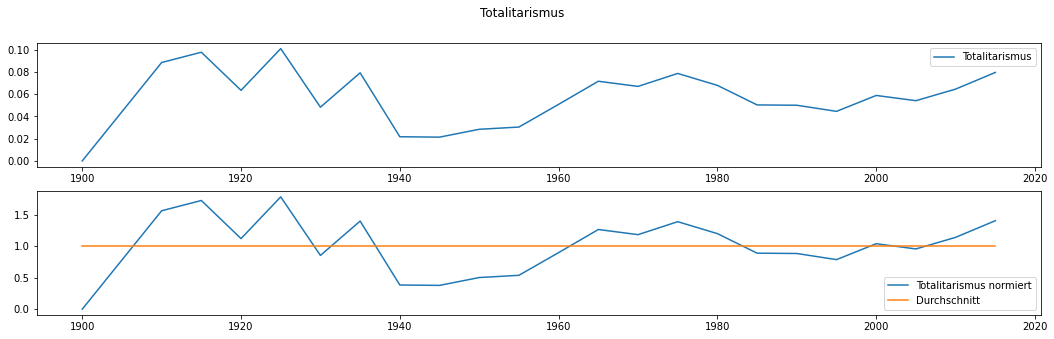

In [21]:
fig, ax = plt.subplots(2,1)
fig.set_size_inches(18,5)
fig.suptitle('Totalitarismus')
ax[0].plot([x[0] for x in totalitarismus], [x[1] for x in totalitarismus])
ax[1].plot([x[0] for x in totalitarismus_norm], [x[1] for x in totalitarismus_norm])
ax[1].plot(list(range(1900,2020,5)), [1]*24)
ax[0].legend(['Totalitarismus'])
ax[1].legend(['Totalitarismus normiert', 'Durchschnitt'])

Das gleiche Vorgehen wird nun für alle zu betrachtenden Topics wiederholt.

<h2> Thema Bedrohungen für Leib und Leben</h2>

<h3>Topics</h3>

<b> Militär </b>

In [22]:
military=doit(17,corpus1,model1)
military_norm=score_norm(military, 3)

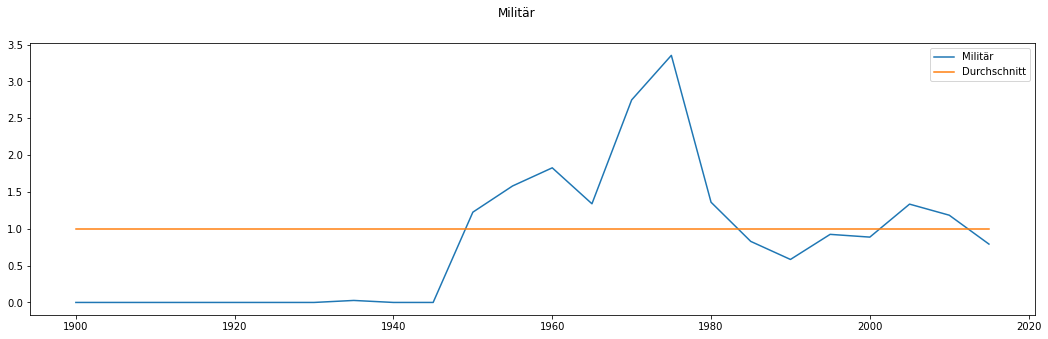

In [26]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(18,5)
fig.suptitle('Militär')
ax.plot([x[0] for x in military_norm], [x[1] for x in military_norm])
ax.plot(list(range(1900,2020,5)), [1]*24)
ax.legend(['Militär', 'Durchschnitt'])

<b> Globaler Konflikt </b>

In [23]:
politics=doit(8,corpus2,model2)
politics_norm=score_norm(politics,3)

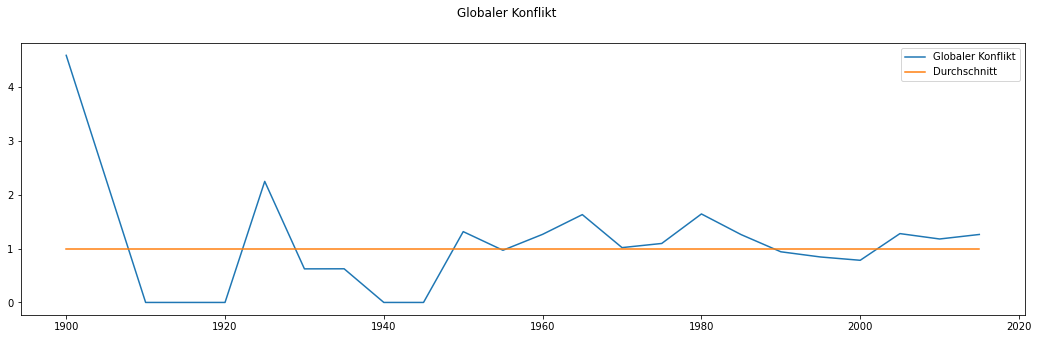

In [28]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(18,5)
fig.suptitle('Globaler Konflikt')
ax.plot([x[0] for x in politics_norm], [x[1] for x in politics_norm])
ax.plot(list(range(1900,2020,5)), [1]*24)
ax.legend(['Globaler Konflikt', 'Durchschnitt'])

<b> Virus </b>

In [24]:
virus=doit(0,corpus2,model2)
virus_norm=score_norm(virus,3)

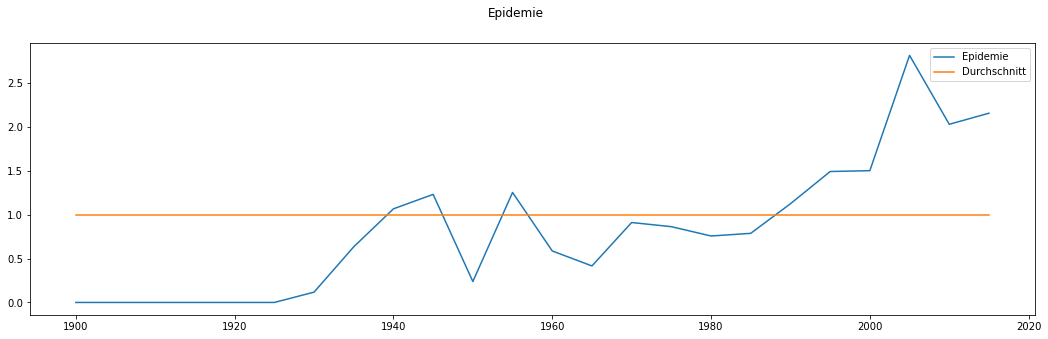

In [79]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(18,5)
fig.suptitle('Epidemie')
ax.plot([x[0] for x in virus_norm], [x[1] for x in virus_norm])
ax.plot(list(range(1900,2020,5)), [1]*24)
ax.legend(['Epidemie', 'Durchschnitt'])

<b>Naturkatastrophe</b>

In [25]:
nature=doit(14,corpus2,model2)
nature_norm=score_norm(nature, 3)

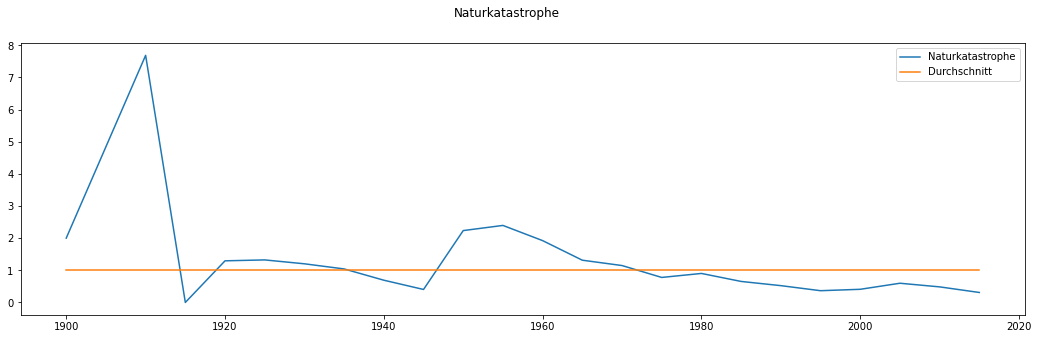

In [32]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(18,5)
fig.suptitle('Naturkatastrophe')
ax.plot([x[0] for x in nature_norm], [x[1] for x in nature_norm])
ax.plot(list(range(1900,2020,5)), [1]*24)
ax.legend(['Naturkatastrophe', 'Durchschnitt'])

<b> Monster </b>

In [26]:
monsters=doit(24,corpus2,model2)
monsters_norm=score_norm(monsters,3)

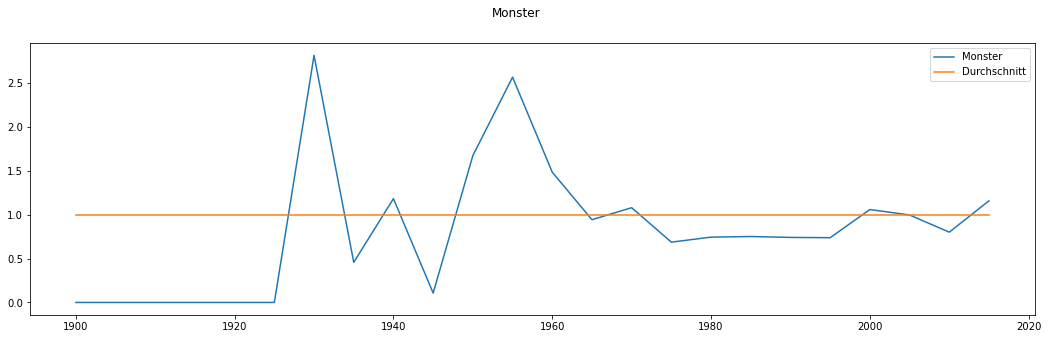

In [34]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(18,5)
fig.suptitle('Monster')
ax.plot([x[0] for x in monsters_norm], [x[1] for x in monsters_norm])
ax.plot(list(range(1900,2020,5)), [1]*24)
ax.legend(['Monster', 'Durchschnitt'])

<h3> Gesamtgraph Leben </h3>

Zum Thema Bedrohungen für Leib und Leben werden die Topics Militärische Auseinandesetzung, Globaler Konflikt, Epidemie, Naturkatastrophe und Monster zusammengefasst. Der finale Score entspricht dem Durchschnitt der normierten Scores.

In [27]:
life_topics=[military_norm, politics_norm, virus_norm,nature_norm,monsters_norm]
life = [sum([x[i][1] for x in life_topics])/len(life_topics) for i in range(len(military))]

In [36]:
life

[1.3188496297253829,
 1.5375738853864616,
 0.0,
 0.2589893859528027,
 0.7147293343364906,
 0.9523870437564408,
 0.5574934901128015,
 0.5886533583092888,
 0.34864831967227633,
 1.338026315499922,
 1.7542174822745786,
 1.4179926220878798,
 1.1292393437204469,
 1.3817142368130608,
 1.3561193039979647,
 1.0820784061124684,
 0.8566586216903278,
 0.7830562610321747,
 0.8732666700952617,
 0.9284115247172959,
 1.4054407054593567,
 1.1363322679583252,
 1.1365453064008344]

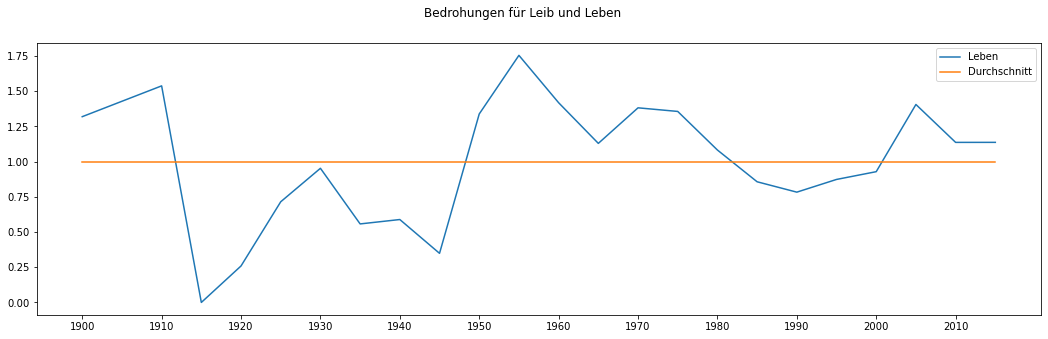

In [28]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(18,5)
fig.suptitle('Bedrohungen für Leib und Leben')
ax.plot([x[0] for x in monsters], [x for x in life])
ax.plot(list(range(1900,2020,5)), [1]*24)
ax.set_xticks(list(range(1900,2020,10)))
ax.legend(['Leben', 'Durchschnitt'])
plt.savefig('life_big')

<h3>Übersicht: Bedrohungen für Leib und Leben</h3>

Alle dem Thema Leben zugeordneten Topics im Vergleich:

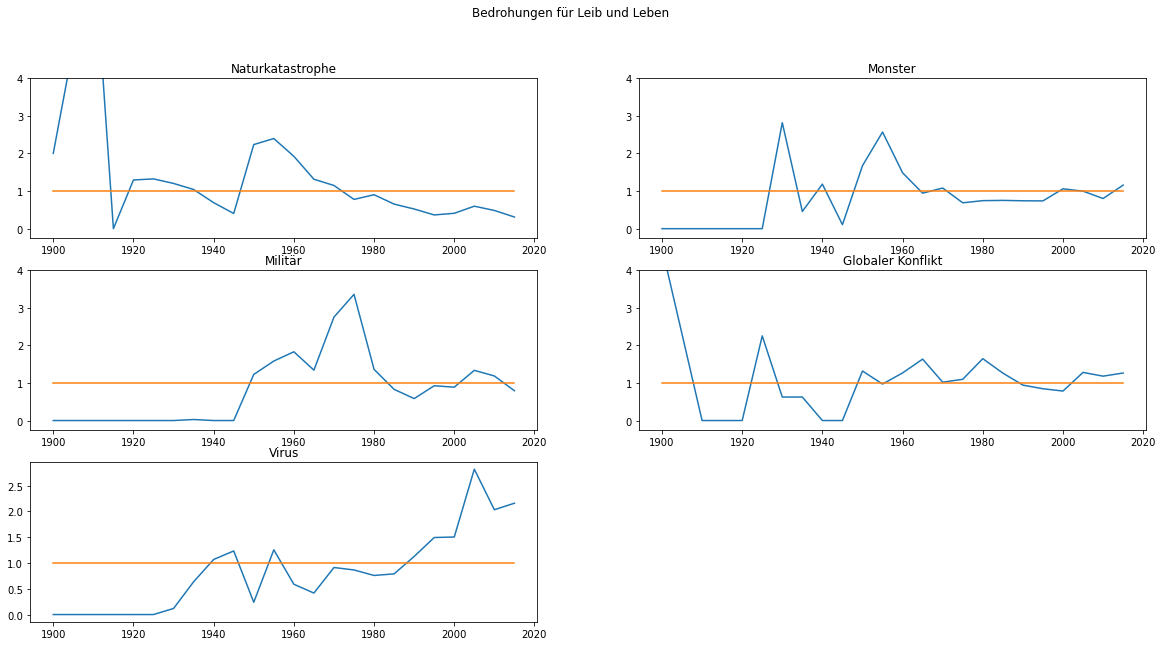

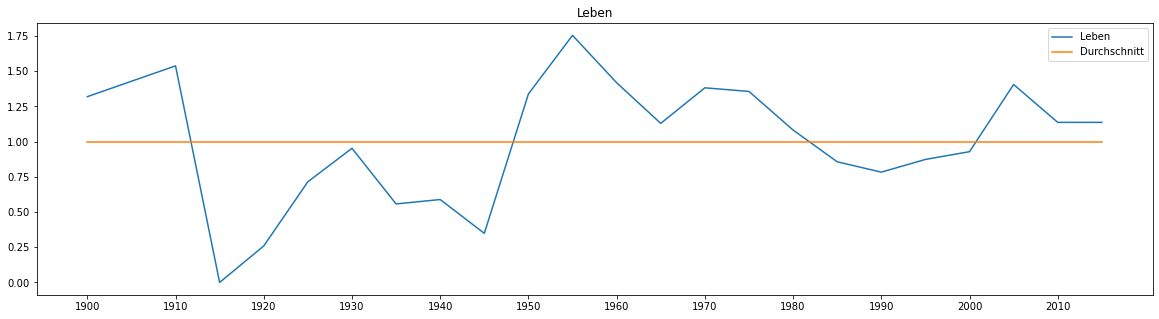

In [85]:
fig, ax = plt.subplots(3,2)
fig.set_size_inches(20,10)
fig.suptitle('Bedrohungen für Leib und Leben')
#
ax[0][0].plot([x[0] for x in nature_norm], [x[1] for x in nature_norm])
ax[0][1].plot([x[0] for x in monsters_norm], [x[1] for x in monsters_norm])
ax[1][0].plot([x[0] for x in military_norm], [x[1] for x in military_norm])
ax[1][1].plot([x[0] for x in politics_norm], [x[1] for x in politics_norm])
ax[2][0].plot([x[0] for x in virus_norm], [x[1] for x in virus_norm])
ax[2][0].plot(list(range(1900,2020,5)), [1]*24)

for axs in ax[:2]:
    for a in axs:
        a.plot(list(range(1900,2020,5)), [1]*24)
        a.set_ylim(-.25,4)
#
ax[0][0].set_title('Naturkatastrophe')
ax[0][1].set_title('Monster')
ax[1][0].set_title('Militär')
ax[1][1].set_title('Globaler Konflikt')
ax[2][0].set_title('Virus')
plt.delaxes(ax[2][1])
plt.savefig('overview_life')

fig2, ax2 = plt.subplots(1,1)
fig2.set_size_inches(20,5)
ax2.set_title('Leben')
ax2.plot([x[0] for x in virus_norm], [x for x in life])
ax2.plot(list(range(1900,2020,5)), [1]*24)
ax2.set_xticks(list(range(1900,2020,10)))
ax2.legend(['Leben', 'Durchschnitt'])
plt.savefig('overview_life2')

<h2> Thema Bedrohungen für die Autonomie </h2>

<h3>Topics</h3>

<b> Künstliche Intelligenz </b>

In [29]:
AI=doit(21,corpus1,model1)
AI_norm=score_norm(AI, 3)

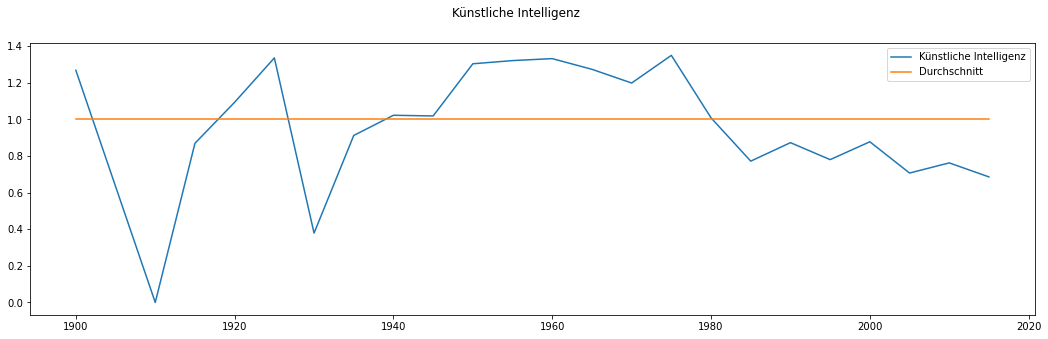

In [47]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(18,5)
fig.suptitle('Künstliche Intelligenz')
ax.plot([x[0] for x in AI_norm], [x[1] for x in AI_norm])
ax.plot(list(range(1900,2020,5)), [1]*24)
ax.legend(['Künstliche Intelligenz', 'Durchschnitt'])

<b> Secret Intelligence </b>

In [30]:
secret=doit(19,corpus1,model1)
secret_norm=score_norm(secret, 3)

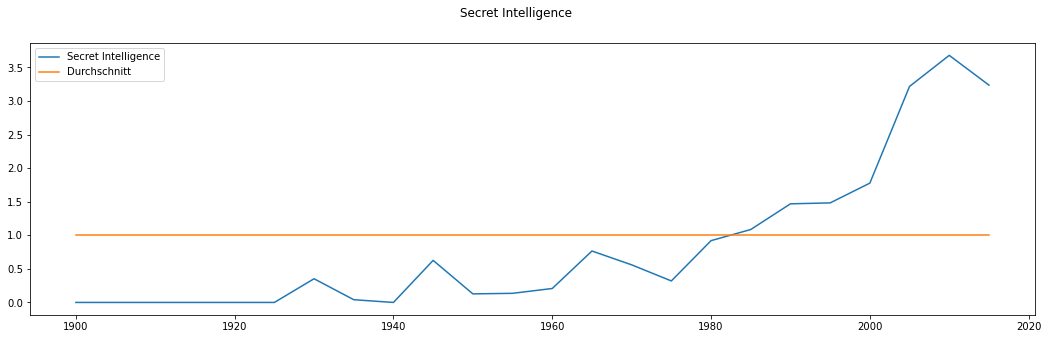

In [49]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(18,5)
fig.suptitle('Secret Intelligence')
ax.plot([x[0] for x in secret_norm], [x[1] for x in secret_norm])
ax.plot(list(range(1900,2020,5)), [1]*24)
ax.legend(['Secret Intelligence', 'Durchschnitt'])

<b> Biotechnologie </b>

In [31]:
biotech=doit(9,corpus2,model2)
biotech_norm=score_norm(biotech,3)

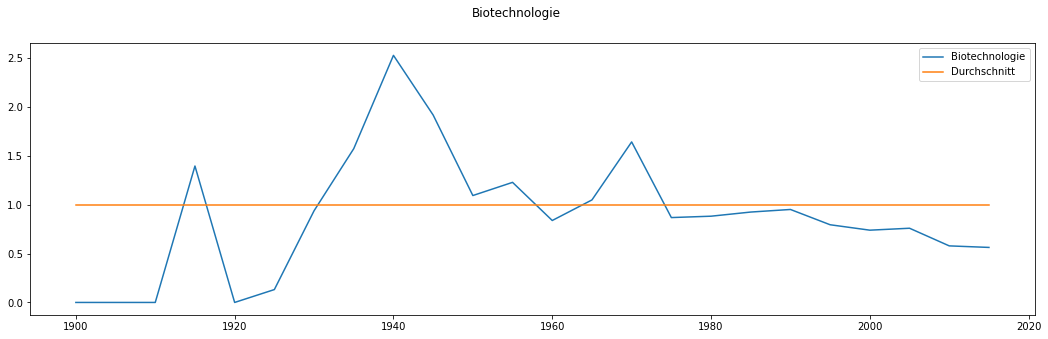

In [51]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(18,5)
fig.suptitle('Biotechnologie')
ax.plot([x[0] for x in biotech_norm], [x[1] for x in biotech_norm])
ax.plot(list(range(1900,2020,5)), [1]*24)
ax.legend(['Biotechnologie', 'Durchschnitt'])

<h3>Gesamtgraph Autonomie</h3>

Zum Thema Bedrohungen für die Autonomie werden die Topics AI, Secret Intelligence, Totalitarismus und Biotechnologie zusammengefasst.

In [32]:
autonomy_topics=[AI_norm, secret_norm, totalitarismus_norm,biotech_norm]
autonomy = [sum([x[i][1] for x in autonomy_topics])/len(autonomy_topics) for i in range(len(AI_norm))]

In [53]:
autonomy

[0.31689582654289616,
 0.3906909192214396,
 0.9977663475140297,
 0.5536168896228765,
 0.8126140907908451,
 0.6307089597135838,
 0.9812893537481417,
 0.9835308129225548,
 0.9849185594254857,
 0.7567666451610024,
 0.8057054345823202,
 0.8190179553948098,
 1.0882111842148305,
 1.1459617167994955,
 0.9818274761171464,
 1.0025371448962397,
 0.9178838054697015,
 1.0440844178786592,
 0.9609627985261248,
 1.108241605926011,
 1.4097545076775706,
 1.5400290507505021,
 1.4723375903820977]

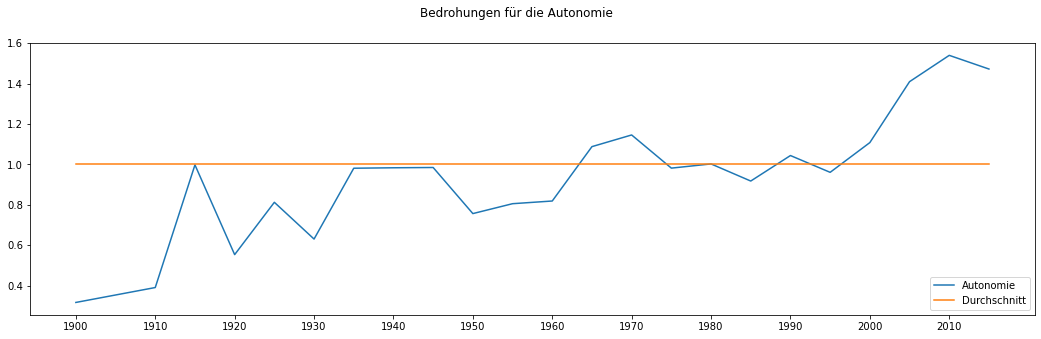

In [56]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(18,5)
fig.suptitle('Bedrohungen für die Autonomie')
ax.plot([x[0] for x in monsters], [x for x in autonomy])
ax.plot(list(range(1900,2020,5)), [1]*24)
ax.set_xticks(list(range(1900,2020,10)))
ax.legend(['Autonomie', 'Durchschnitt'], loc="lower right")
plt.savefig('autonomy_big')

<h3>Übersicht Autonomie</h3>

Im folgenden sehen wir alle dem Thema Autonomie zugeordneten Topics im Vergleich sowie den Gesamtgraphen.

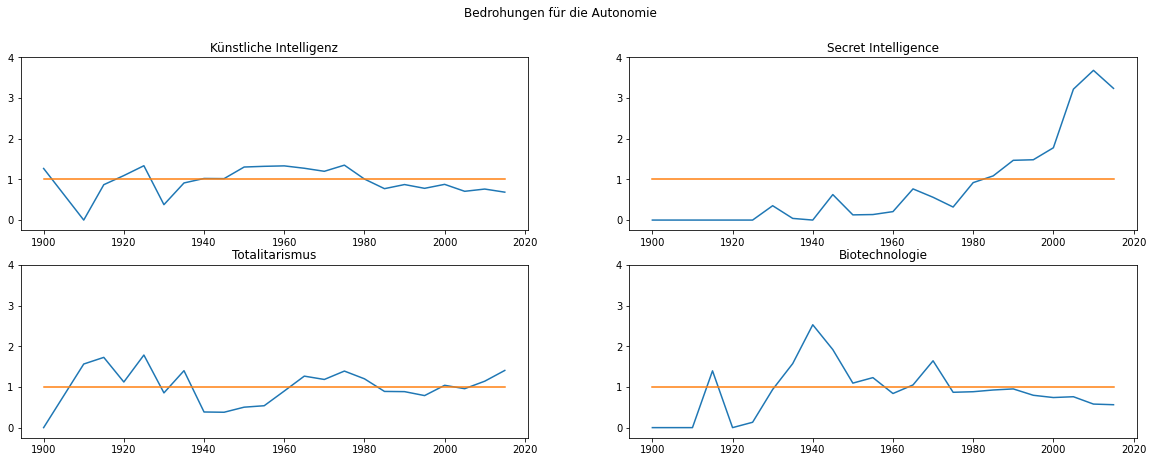

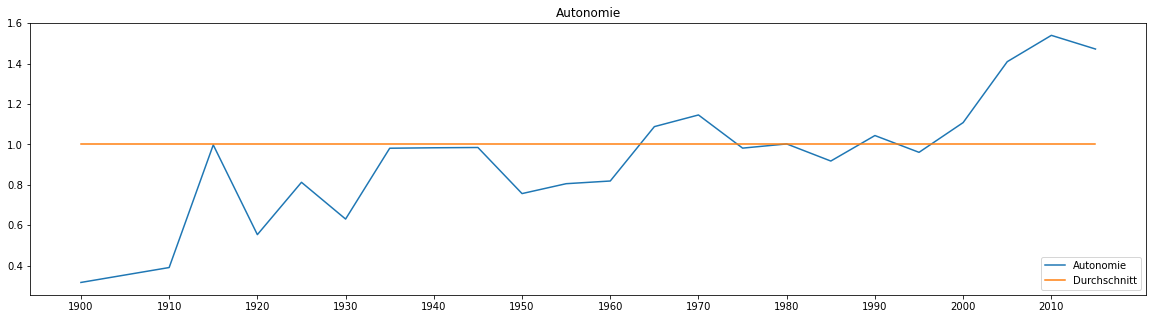

In [61]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(20,7)
fig.suptitle('Bedrohungen für die Autonomie')

ax[0][0].plot([x[0] for x in AI_norm], [x[1] for x in AI_norm])
ax[0][1].plot([x[0] for x in secret_norm], [x[1] for x in secret_norm])
ax[1][0].plot([x[0] for x in totalitarismus_norm], [x[1] for x in totalitarismus_norm])
ax[1][1].plot([x[0] for x in biotech_norm], [x[1] for x in biotech_norm])
for axs in ax:
    for a in axs:
        a.plot(list(range(1900,2020,5)), [1]*24)
        a.set_ylim(-.25,4)
ax[0][0].set_title('Künstliche Intelligenz')
ax[0][1].set_title('Secret Intelligence')
ax[1][0].set_title('Totalitarismus')
ax[1][1].set_title('Biotechnologie')
plt.savefig('overview_autonomy')

fig2, ax2 = plt.subplots(1,1)
fig2.set_size_inches(20,5)
ax2.plot([x[0] for x in AI], [x for x in autonomy])
ax2.plot(list(range(1900,2020,5)), [1]*24)
ax2.set_xticks(list(range(1900,2020,10)))
ax2.legend(['Autonomie', 'Durchschnitt'], loc="lower right")
ax2.set_title('Autonomie')
plt.savefig('overview_autonomy2')

<h2> Vergleich: Leben vs. Autonomie </h2>

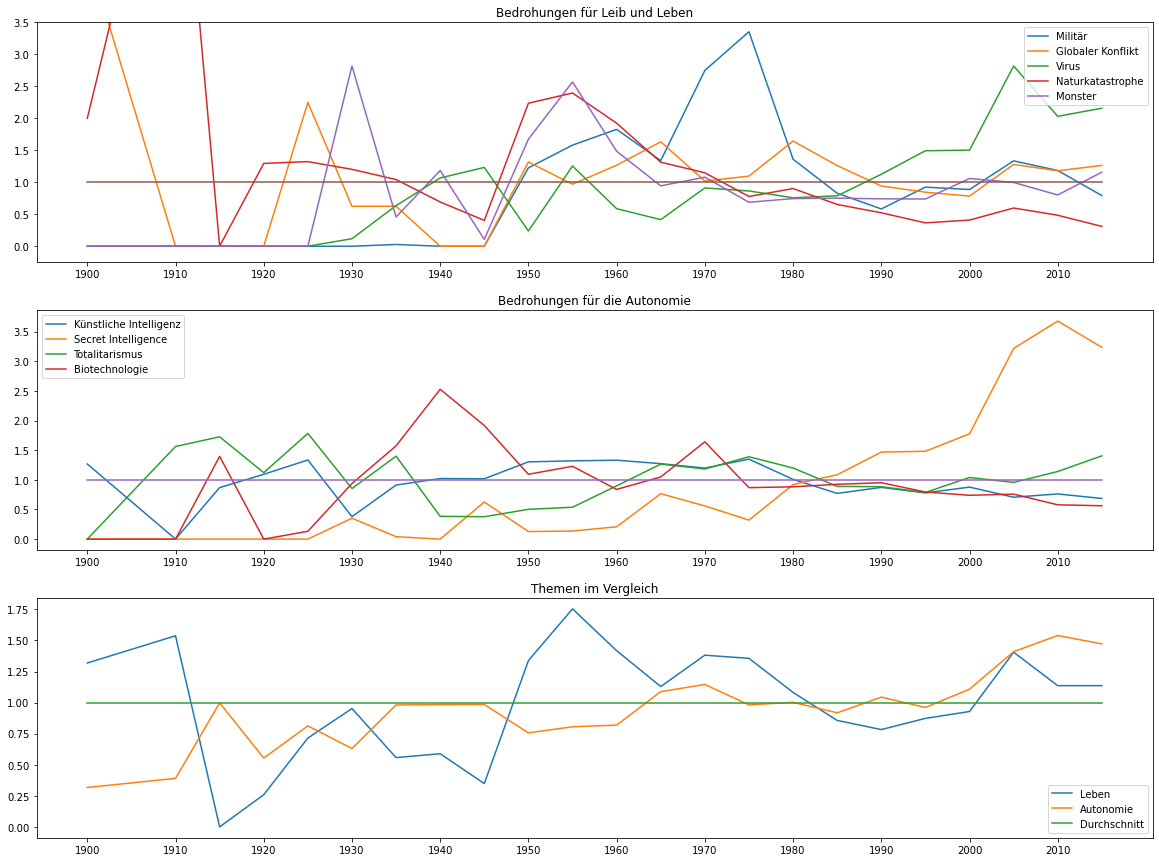

In [39]:
fig, ax = plt.subplots(3,1)
fig.set_size_inches(20,15)
#fig.suptitle('Bedrohung für Autonomie')
ax[0].plot([x[0] for x in military_norm], [x[1] for x in military_norm])
ax[0].plot([x[0] for x in politics_norm], [x[1] for x in politics_norm])
ax[0].plot([x[0] for x in virus_norm], [x[1] for x in virus_norm])
ax[0].plot([x[0] for x in nature_norm], [x[1] for x in nature_norm])
ax[0].plot([x[0] for x in monsters_norm], [x[1] for x in monsters_norm])
ax[0].plot(list(range(1900,2020,5)), [1]*24)
ax[0].set_xticks(list(range(1900,2020,10)))
ax[0].set_ylim(-.25,3.5)
ax[0].legend(['Militär','Globaler Konflikt','Virus','Naturkatastrophe', 'Monster'])
ax[0].set_title('Bedrohungen für Leib und Leben')
#plt.savefig('life_all')

ax[1].plot([x[0] for x in AI_norm], [x[1] for x in AI_norm])
ax[1].plot([x[0] for x in secret_norm], [x[1] for x in secret_norm])
ax[1].plot([x[0] for x in totalitarismus_norm], [x[1] for x in totalitarismus_norm])
ax[1].plot([x[0] for x in biotech_norm], [x[1] for x in biotech_norm])
ax[1].plot(list(range(1900,2020,5)), [1]*24)
ax[1].set_xticks(list(range(1900,2020,10)))
ax[1].legend(['Künstliche Intelligenz','Secret Intelligence','Totalitarismus','Biotechnologie'])
ax[1].set_title('Bedrohungen für die Autonomie')
#plt.savefig('autonomy_all')

ax[2].plot([x[0] for x in secret_norm], [x for x in life])
ax[2].plot([x[0] for x in secret_norm], [x for x in autonomy])
ax[2].plot(list(range(1900,2020,5)), [1]*24)
ax[2].set_xticks(list(range(1900,2020,10)))
ax[2].legend(['Leben','Autonomie','Durchschnitt'],loc="lower right")
ax[2].set_title('Themen im Vergleich')
plt.savefig('lifeVsAutonomy')